# Overview :

In this notebook, we do an explanatory data analysis to extract some insight from our dataset.

In [1]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
from datetime import datetime
from wordcloud import WordCloud 
sns.set_theme()

In [2]:
os.chdir("../..")

In [3]:
from doc.core.encoding import FastEncoding

## Overview of the company data :

In [4]:
companyValue_data = pd.read_csv("./data/CompanyValues.csv")
companyValue_data.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [5]:
companyValue_data.loc[:,"day_date"] = pd.to_datetime(companyValue_data["day_date"])

**We might want to limit our analysis to predicting whether the value will increase the next week/month instead of the next day**

In [6]:
companyValue_data_Monthly = companyValue_data.set_index('day_date').groupby([pd.Grouper(freq="M"),"ticker_symbol"]).mean()

Text(0.5, 1.0, 'Evolution of the open value of different stocks')

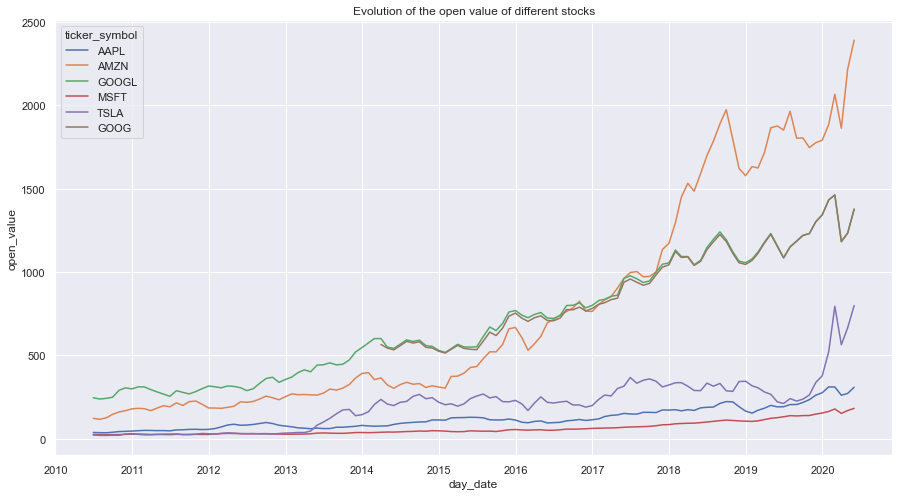

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=companyValue_data_Monthly.reset_index(),x="day_date",y="open_value",hue="ticker_symbol",ax=ax)
ax.set_title("Evolution of the open value of different stocks")

In [8]:
# We compute whether the open value of the stock price has increased
# in the next week or not. As a base encoding :
#   *   -1 means the open value will decrease in the next week;
#   *    1 means the open value will increase in the next week
grouped_companyValue_data = companyValue_data_Monthly.groupby(level="ticker_symbol",group_keys=False)
companyValue_data_Monthly["value_evolution"] = grouped_companyValue_data.apply(
    lambda x : 2*(x["open_value"]<=x.shift(-1)["open_value"]).astype(int)-1
    )

Text(0.5, 1.0, "Distribution of stocks' evolution")

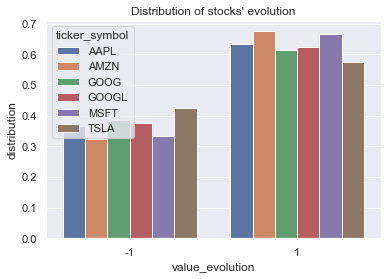

In [9]:
dist = companyValue_data_Monthly.groupby("ticker_symbol")["value_evolution"].apply(lambda x : x.value_counts()/len(x))
dist = dist.rename("distribution").reset_index()
dist = dist.rename(columns={"level_1" : "value_evolution"})
sns.barplot(data=dist,x="value_evolution",y="distribution",hue="ticker_symbol")
plt.title("Distribution of stocks' evolution")

# Overview of the tweet data :

In [10]:
tweets_data = pd.read_parquet("./output/preprocessed_tweets.parquet")
tweets_data.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,body_preprocessed
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,"[check, learn, howtotrade]"
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,"[insanity, today, weirdo, massive, selling, bi..."
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,"[stock, performance]"
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,"[volkswagen, push, record, recall, tally, high]"
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,"[swing, trade, up, return, day, swingtrade, fo..."


In [11]:
company_Tweet = pd.read_csv("./data/Company_Tweet.csv")
company_Tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [12]:
tweets_data = tweets_data.merge(company_Tweet,on="tweet_id")    

In [13]:
# Let's convert the post date from a timestamp
# to date time
tweets_data.loc[:,"post_date"] = tweets_data["post_date"].apply(datetime.fromtimestamp)
tweets_data.set_index("post_date",inplace=True)

In [14]:
tweets_data.head()

,tweet_id,writer,body,comment_num,retweet_num,like_num,body_preprocessed,ticker_symbol
post_date,,,,,,,,
2014-12-31 16:00:57,550441509175443456,VisualStockRSRC,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,"[check, learn, howtotrade]",AAPL
2014-12-31 16:01:36,550441672312512512,KeralaGuy77,Insanity of today weirdo massive selling. $aap...,0,0,0,"[insanity, today, weirdo, massive, selling, bi...",AAPL
2014-12-31 16:01:50,550441732014223360,DozenStocks,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,"[stock, performance]",AMZN
2014-12-31 16:06:47,550442977802207232,ShowDreamCar,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,"[volkswagen, push, record, recall, tally, high]",TSLA
2014-12-31 16:10:05,550443807834402816,i_Know_First,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,"[swing, trade, up, return, day, swingtrade, fo...",AAPL


## Number of tweets per user and their visibility :

In [15]:
influence_of_tweeters = tweets_data[["tweet_id","writer","comment_num","retweet_num","like_num"]].drop_duplicates()
influence_of_tweeters = influence_of_tweeters.groupby("writer")[["comment_num","retweet_num","like_num"]].mean()
weights = pd.Series([0.5,2,0.5],index=["comment_num","retweet_num","like_num"])
influence_of_tweeters = (influence_of_tweeters * weights).sum(axis=1)
influence_of_tweeters = influence_of_tweeters.rename("visibility")
num_tweets = tweets_data[["tweet_id","writer"]].drop_duplicates()
num_tweets = num_tweets.groupby("writer").count()
num_tweets = num_tweets.rename(columns={"tweet_id":"num_tweets"})
influence_of_tweeters = pd.concat([influence_of_tweeters,num_tweets],axis=1)

We can see that according to our dataset most of the tweeters have a low visibility/influence (depicted has the number of retweets, likes and comments). Moreover, it seems that the more an account has tweets in this dataset the less influential, it is!

In [16]:
print(influence_of_tweeters.describe())

          visibility     num_tweets
count  140131.000000  140131.000000
mean        1.647120      26.194711
std        14.643989     577.326001
min         0.000000       1.000000
25%         0.000000       1.000000
50%         0.500000       1.000000
75%         1.000000       4.000000
max      1362.000000   91741.000000


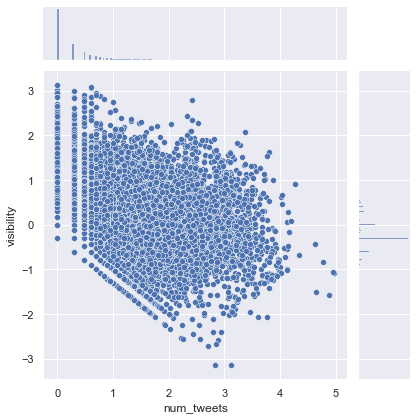

In [17]:
import numpy as np
g = sns.jointplot(data=np.log10(influence_of_tweeters[influence_of_tweeters["visibility"]>0]),x="num_tweets",y="visibility")

Note : Lots of code of bots selling! (High Frequency Trading)

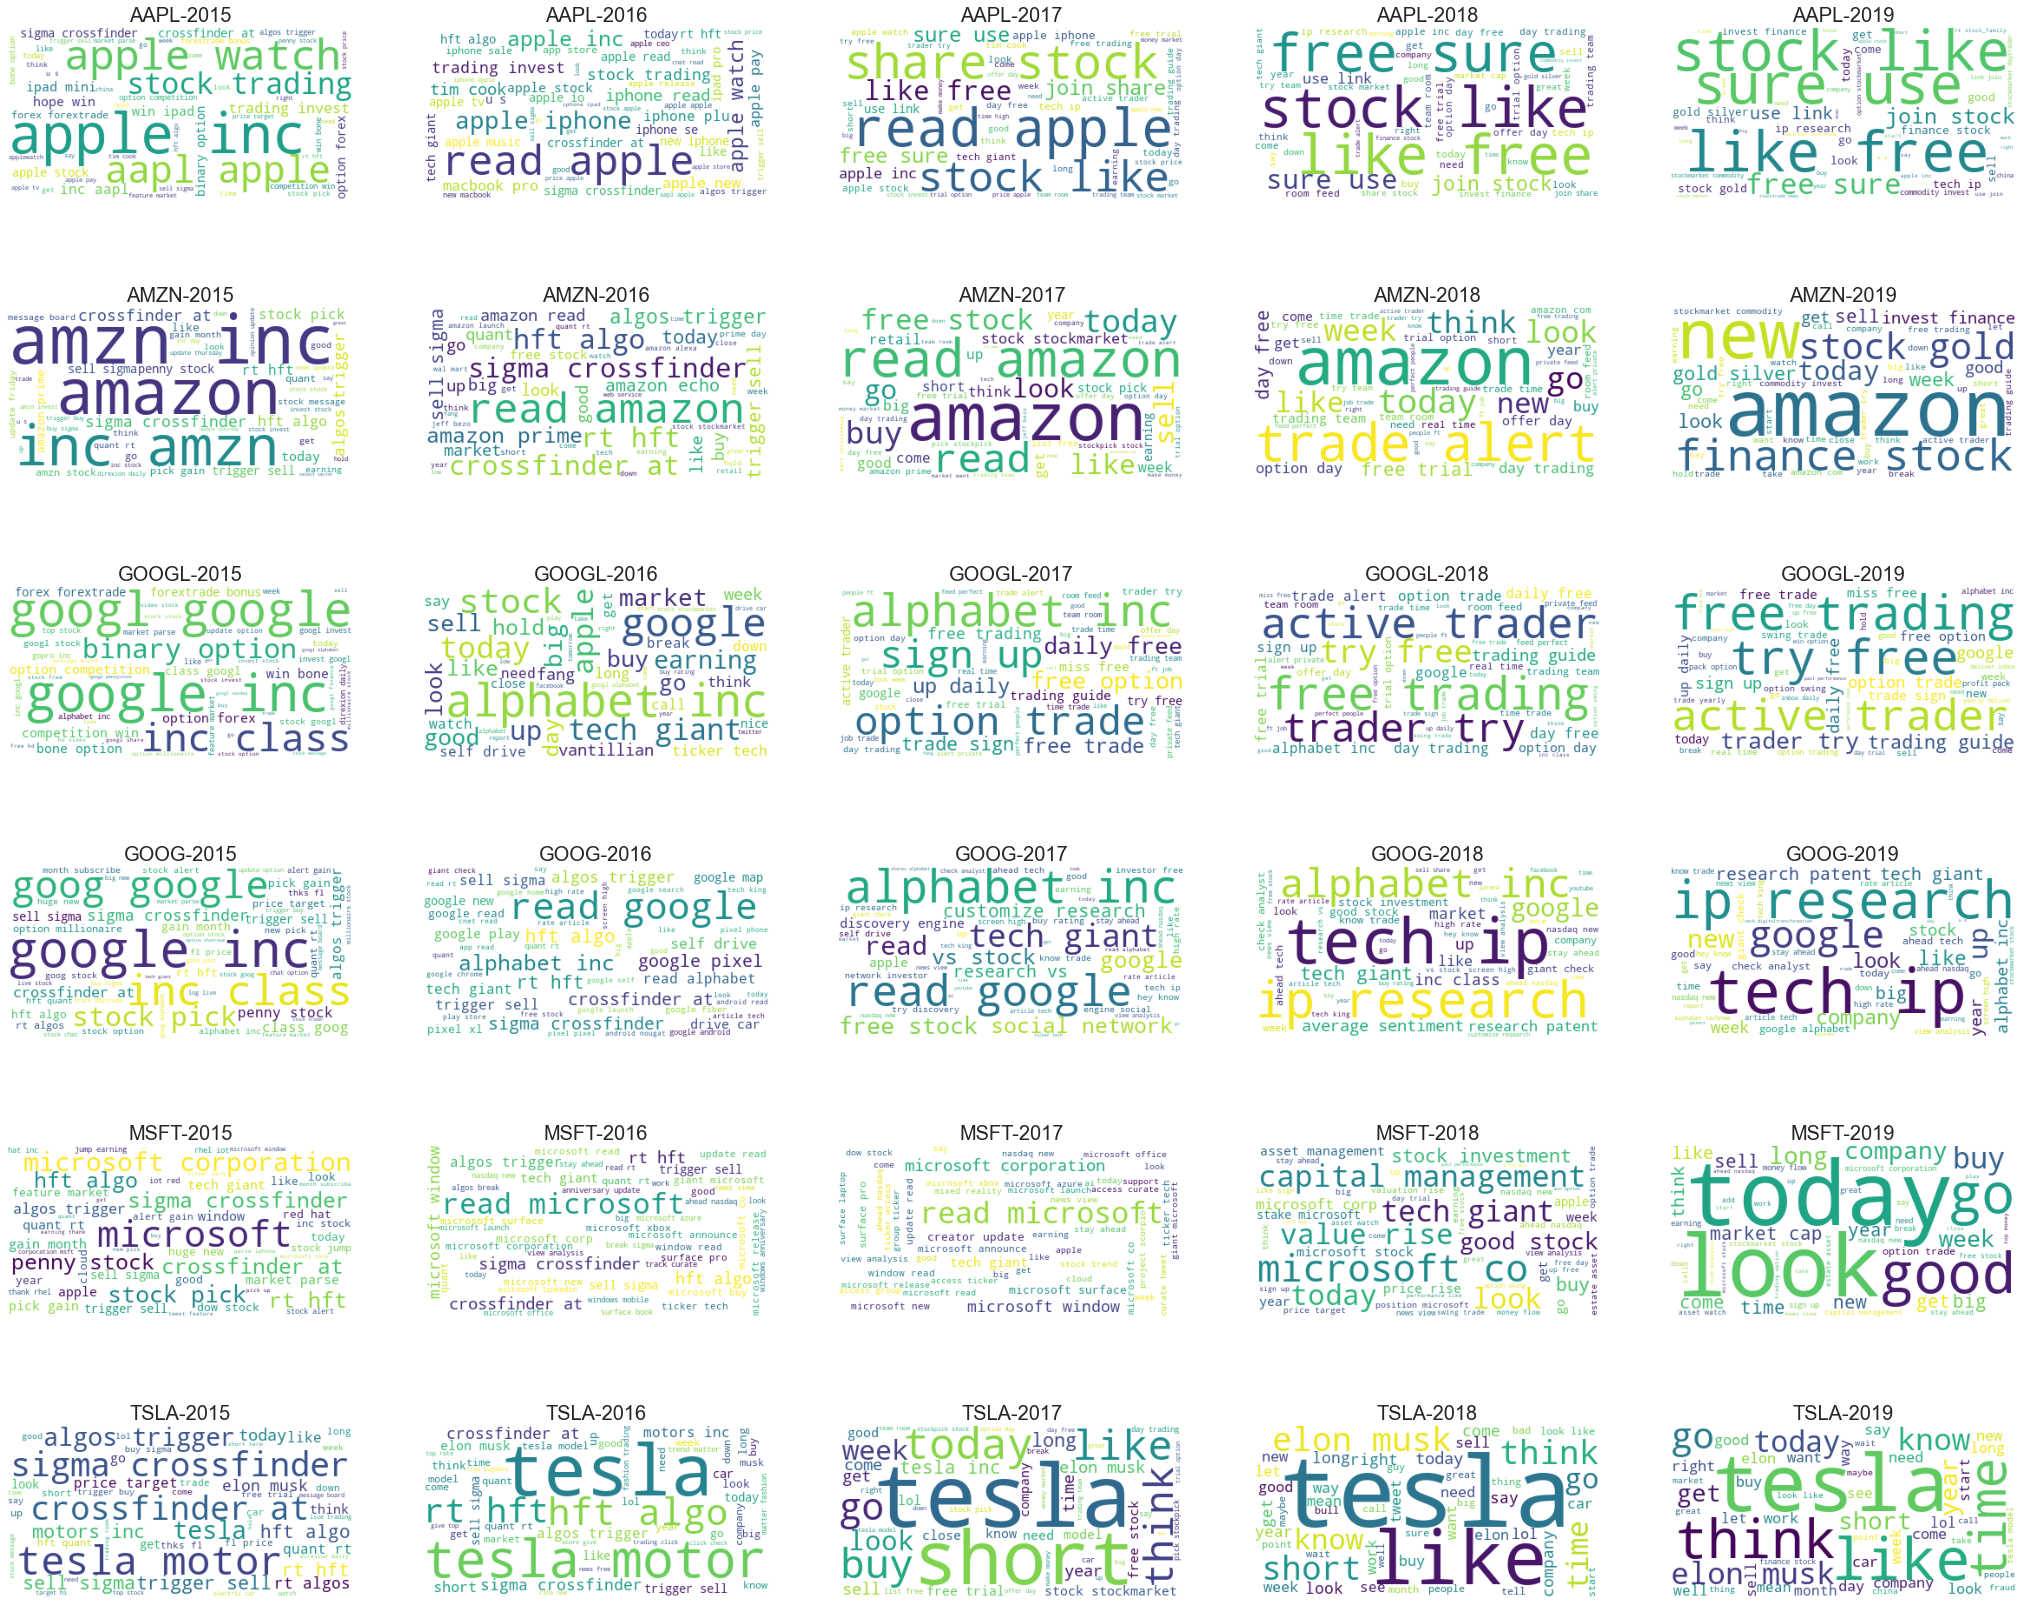

In [18]:
plt.rcParams["figure.figsize"]=(20,15)
ticker_symbols = companyValue_data["ticker_symbol"].unique()
years = ["2015","2016","2017","2018","2019"]
fig,axs = plt.subplots(len(ticker_symbols),len(years),figsize=(36,30))
for i, ticker_symbol in enumerate(ticker_symbols):
    for j, year in enumerate(years):
        text = tweets_data.loc[year].query("ticker_symbol == @ticker_symbol")
        text = " ".join(
            " ".join(i) for i in text["body_preprocessed"])
        wordcloud = WordCloud(background_color="white",max_words=50,stopwords=["p","t","x","ats","lx"]).generate(text)
        axs[i,j].imshow(wordcloud)
        axs[i,j].axis("off")
        axs[i,j].set_title(ticker_symbol+'-'+year,fontsize=20)
axs[2,1].axis("off")
plt.show()

### BoW encoding :

In [19]:
from tqdm import tqdm

def featurizer(data,date,vocab_size):
    encoded_words = [encoding for vector in data.loc[date,"body_vectorized"] for encoding in vector]
    features = np.zeros(10_000)
    for encoding in encoded_words:
        features[encoding]+=1
    return features

def get_correlated_words(ticker_symbol,num_correlated,vocab_size):
    data = tweets_data.query("ticker_symbol==@ticker_symbol")
    encoder = FastEncoding(vocab_size,verbose=True)
    encoder.adapt(data["body_preprocessed"])
    data["body_vectorized"] = encoder(data["body_preprocessed"])
    date_range = [f"{d.year}-{d.month}" for d in pd.date_range("2014-12","2020-01",freq="M")]
    features_map = np.zeros((len(date_range),len(encoder.bow)))
    target_map = np.zeros(len(date_range))
    for i,date in tqdm(enumerate(date_range),total=len(date_range)):
        features_map[i,:] = featurizer(data,date,len(encoder.bow))
        target = companyValue_data_Monthly.loc[date].reset_index()
        target = target.query("ticker_symbol=='AAPL'")["value_evolution"][0]
        target_map[i] = target
    features_map = pd.DataFrame(features_map,columns=[word for word,_ in encoder.bow])
    correlation = features_map.apply(lambda x: x.corr(pd.Series(target_map))).sort_values()
    correlated_features = pd.concat([correlation[:num_correlated],correlation[-num_correlated:]])
    return correlated_features

In [20]:
ticker_symbols = companyValue_data["ticker_symbol"].unique()
most_correlated_features = {}
for ticker_symbol in ticker_symbols:
    print(ticker_symbol)
    most_correlated_features[ticker_symbol] = get_correlated_words(ticker_symbol,10,vocab_size=10_000)

AAPL


100%|██████████| 10862210/10862210 [00:03<00:00, 3217651.81it/s]
<ipython-input-19-207cc56fa5ce>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["body_vectorized"] = encoder(data["body_preprocessed"])
100%|██████████| 61/61 [00:15<00:00,  4.04it/s]


AMZN


100%|██████████| 61/61 [00:03<00:00, 18.37it/s]


GOOGL


100%|██████████| 61/61 [00:01<00:00, 35.15it/s]


GOOG


100%|██████████| 61/61 [00:02<00:00, 28.59it/s]


MSFT


100%|██████████| 61/61 [00:01<00:00, 32.78it/s]


TSLA


100%|██████████| 61/61 [00:07<00:00,  8.59it/s]


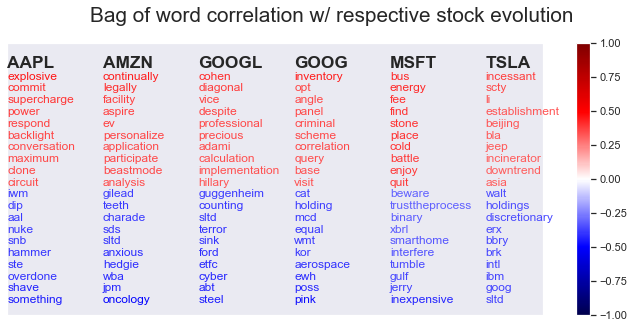

In [21]:
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
cmap = get_cmap("seismic")
fig, ax = plt.subplots(figsize=(12,5))
for i, ticker in enumerate(most_correlated_features):
    for j, word in enumerate(most_correlated_features[ticker].index):
        ax.text(i/3,(j+1)/21, word,c=cmap((most_correlated_features[ticker][j]+1)/2))
    ax.text(i/3,(j+2)/21,ticker,fontsize="x-large",fontweight="bold")
plt.colorbar(ScalarMappable(norm= Normalize(-1,1),cmap=cmap),ax=[ax],location="right")
ax.set_xlim(0,5/3+0.2)
ax.set_ylim(0,1.1)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle("Bag of word correlation w/ respective stock evolution",fontsize="xx-large")
plt.show()

Idea of data visualization to do : (May be do this for different type of aggregating frequency?)
- [x] for each stock and each type of evolution plot a word-cloud adding n-gram to the process
    -   Should expend the set of stop-words (maybe remove the name of the firm mentioned), plus lot of tweets are from bots with irrational text. 
- [x] limit the vocab to K words, and look at the 10 most correlated words to the feature
    
$\hookrightarrow$ Need to construct a fast vocabulary/BoW (could get a very fast BoW using [Cython](https://medium.com/glose-team/%EF%B8%8F-fast-bag-of-words-using-spacy-and-cython-574c308a9ff3) or through multiprocessing again...)

$\hookrightarrow$ remove the less frequent words! From this we can construct both the TF-IDF and a preprocessing layer that can be use to train an embedding layer.